<a href="https://colab.research.google.com/github/FernandoFrancoF/IA/blob/main/ReconocedorFacial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install face_recognition

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.1/100.1 MB 7.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566170 sha256=4fe6b67cef5e4570e8115e24a7b75c6b6ffb6ef5198d204af9e31204639910b4
  Stored in directory: /root/.cache/pip/wheels/7a/eb/cf/e9eced74122b679557f597bb7c8e4c739cfcac526db1fd523d
Successfully built face-recognition-models


In [2]:
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time
import face_recognition



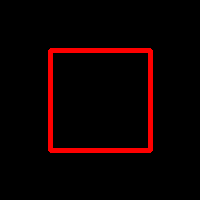

In [35]:
# función para convertir una respuesta JavaScript en una imagen OpenCV BGR
def js_to_image(js_reply):
  """
  Parámetros:
          js_reply: Objeto JavaScript que contiene la imagen de la cámara web
  Retorna:
          img: Imagen OpenCV BGR
  """
  # decodificar la imagen base64
  image_bytes = b64decode(js_reply.split(',')[1])
  # convertir bytes a un array numpy
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decodificar el array numpy en una imagen OpenCV BGR
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# función para convertir una imagen de cuadro delimitador de OpenCV en una cadena de bytes base64 para superponerla en el flujo de video
def bbox_to_bytes(bbox_array):
  """
  Parámetros:
          bbox_array: Array numpy (píxeles) que contiene el rectángulo para superponer en el flujo de video.
  Retorna:
        bytes: Cadena de bytes de imagen base64
  """
  # convertir array en imagen PIL
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # formatear bbox en png para retorno
  bbox_PIL.save(iobuf, format='png')
  # formatear cadena de retorno
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))



In [9]:
Fer_image = face_recognition.load_image_file("/content/sample_data/Fernando.jpeg")
Fer_face_encoding = face_recognition.face_encodings(Fer_image)[0]

Dani_image = face_recognition.load_image_file("/content/sample_data/Daniel.jpeg")
Dani_face_encoding = face_recognition.face_encodings(Dani_image)[0]

known_face_encodings = [
    Fer_face_encoding,
    Dani_face_encoding
]
known_face_names = [
    "Fernando",
    "Daniel"
]

In [31]:
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)

  # obtener datos de la foto
  data = eval_js('takePhoto({})'.format(quality))
  # obtener imagen en formato OpenCV
  img = js_to_image(data)

  face_locations = face_recognition.face_locations(img)
  face_encodings = face_recognition.face_encodings(img, face_locations)

  for (top, right, bottom, left), face_encoding in zip(face_locations, face_encodings):
    matches = face_recognition.compare_faces(known_face_encodings, face_encoding)
    name = "Unknown"
    face_distances = face_recognition.face_distance(known_face_encodings, face_encoding)
    best_match_index = np.argmin(face_distances)
    if matches[best_match_index]:
      name = known_face_names[best_match_index]
    cv2.rectangle(img, (left, top), (right, bottom), (0, 0, 255), 2)
    cv2.rectangle(img, (left, bottom - 35), (right, bottom), (0, 0, 255), cv2.FILLED)
    font = cv2.FONT_HERSHEY_DUPLEX
    cv2.putText(img, name, (left + 6, bottom - 6), font, 1.0, (255, 255, 255), 1)
 # dibujar cuadro delimitador de rostro en la imagen
  # para (x, y, w, h) en caras:
  # img = cv2.rectangle(img, (x, y), (x+w, y+h), (255,0,0), 2)
  # guardar imagen

  cv2.imwrite(filename, img)

  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


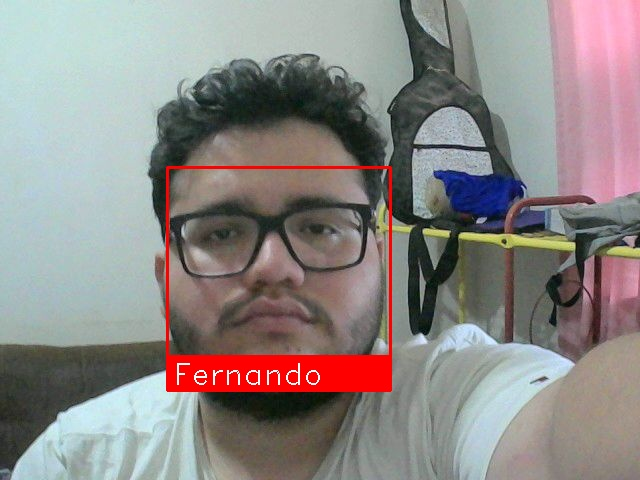

In [41]:
try:
  filename = take_photo('photo.jpg')
  print('Saved to {}'.format(filename))

  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))